In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision as vision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
import tarfile

In [3]:
ds=CIFAR10(root="data/",download=True,transform=transforms.ToTensor(),train=True)

Extracting data/cifar-10-python.tar.gz to data/


torch.Size([3, 32, 32])


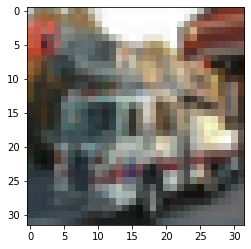

In [4]:
i,j=ds[900]
print(i.shape)
plt.imshow(i.permute(1,2,0))


In [5]:
j

9

In [6]:
dl=DataLoader(ds,batch_size=128,shuffle=True)

In [7]:
ds.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

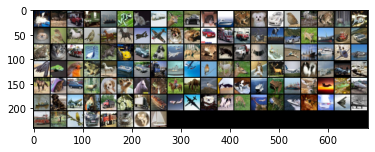

In [8]:
for i,j in dl:
    plt.imshow(make_grid(i,nrow=20).permute(1,2,0))
    break
    


# custom cnn model

In [9]:
def cnn(img,k):
    ri,ci=img.shape
    rk,ck=k.shape
    ro,co=ri-rk+1,ci-ck+1
    out=torch.zeros(ro,co)
    for i in range(ro):
        for j in range(co):
            out[i,j]=torch.sum(img[i:i+rk,j:j+ck])
    return out

In [10]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

In [11]:
cnn(sample_image, sample_kernel)

tensor([[15., 15., 15.],
        [ 9., 11., 16.],
        [10.,  7., 12.]])

# simple cnn

In [12]:
model=nn.Sequential(
    nn.Conv2d(3,8,stride=1,kernel_size=3,padding=1),    
    nn.MaxPool2d(2,2)
    
)

In [13]:
for i,j in dl:
    print(i.shape)
    pred=model(i)
    print(pred.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 8, 16, 16])


# cnn

In [14]:
class cnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    def forward(self,xb):
        x=self.pool(F.relu(self.conv1(xb)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
        
        

In [15]:
model=cnnModel()

In [96]:
for i,j in dl:
    print(model(i))
    break

tensor([[ 0.0062, -0.1109,  0.1293,  ...,  0.1302,  0.0370,  0.1107],
        [ 0.0030, -0.1099,  0.1297,  ...,  0.1336,  0.0418,  0.1072],
        [-0.0063, -0.1076,  0.1182,  ...,  0.1174,  0.0255,  0.1011],
        ...,
        [-0.0002, -0.1063,  0.1284,  ...,  0.1250,  0.0417,  0.1085],
        [-0.0029, -0.1072,  0.1166,  ...,  0.1187,  0.0319,  0.1026],
        [-0.0027, -0.1152,  0.1217,  ...,  0.1132,  0.0337,  0.1020]],
       grad_fn=<AddmmBackward>)


In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device=get_default_device()
dl=DeviceDataLoader(dl,device)

In [22]:
model=cnnModel()
to_device(model,device)

cnnModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
def accuracy(pred,label):
    _,p=torch.max(pred,dim=1)
    return torch.tensor(torch.sum(p==label).item()/len(pred)*100)

In [35]:
def fit(epoch,lr,model,loss,data):
    optim=torch.optim.SGD(model.parameters(),lr=lr)
    for i in range(epoch):
        for img,l in data:
            pred=model(img)
            ls=loss(pred,l)
            ls.backward()
            optim.step()
            optim.zero_grad()
            acc=accuracy(pred,l)
            print(f"loss={ls} acc={acc}%")
        

In [36]:
loss=nn.CrossEntropyLoss()
fit(10,0.00005,model,loss,dl)

loss=1.0038286447525024 acc=60.9375%
loss=1.0936696529388428 acc=64.0625%
loss=1.0402613878250122 acc=67.1875%
loss=1.058874249458313 acc=65.625%
loss=1.0028536319732666 acc=64.84375%
loss=0.992737889289856 acc=64.84375%
loss=0.9654060006141663 acc=65.625%
loss=0.9881826043128967 acc=62.5%
loss=1.0989272594451904 acc=58.59375%
loss=1.0163997411727905 acc=65.625%
loss=0.9831335544586182 acc=60.9375%
loss=1.0598822832107544 acc=64.0625%
loss=0.9402761459350586 acc=65.625%
loss=0.9186556339263916 acc=64.0625%
loss=1.064619541168213 acc=63.28125%
loss=1.1485718488693237 acc=62.5%
loss=1.1945362091064453 acc=53.125%
loss=0.9670299291610718 acc=67.1875%
loss=1.1723310947418213 acc=58.59375%
loss=1.0236170291900635 acc=67.96875%
loss=0.8956986665725708 acc=64.84375%
loss=1.1088788509368896 acc=56.25%
loss=1.1128928661346436 acc=64.0625%
loss=1.0242255926132202 acc=61.71875%
loss=1.1554722785949707 acc=55.46875%
loss=1.0866459608078003 acc=60.15625%
loss=0.9961578249931335 acc=68.75%
loss=1.08

loss=1.1525094509124756 acc=58.59375%
loss=1.1129891872406006 acc=62.5%
loss=1.050857424736023 acc=63.28125%
loss=1.2152925729751587 acc=57.8125%
loss=1.1834405660629272 acc=53.90625%
loss=0.9380947351455688 acc=63.28125%
loss=1.1370292901992798 acc=61.71875%
loss=1.211837649345398 acc=57.03125%
loss=1.1051586866378784 acc=57.8125%
loss=0.9888619780540466 acc=65.625%
loss=0.9988754391670227 acc=64.84375%
loss=1.1585017442703247 acc=57.8125%
loss=1.0465590953826904 acc=61.71875%
loss=1.0768595933914185 acc=55.46875%
loss=0.9294445514678955 acc=69.53125%
loss=1.0050462484359741 acc=67.1875%
loss=1.0321890115737915 acc=67.1875%
loss=1.106966257095337 acc=60.9375%
loss=1.0878562927246094 acc=67.96875%
loss=0.9681280851364136 acc=69.53125%
loss=1.0700058937072754 acc=59.375%
loss=0.9899038076400757 acc=63.28125%
loss=1.0348130464553833 acc=59.375%
loss=1.2568738460540771 acc=60.15625%
loss=1.0546557903289795 acc=59.375%
loss=0.9350622296333313 acc=67.96875%
loss=1.152388572692871 acc=60.937

loss=1.0906563997268677 acc=64.0625%
loss=1.0287882089614868 acc=58.59375%
loss=1.154522180557251 acc=55.46875%
loss=1.0655916929244995 acc=58.59375%
loss=1.2511546611785889 acc=58.59375%
loss=1.207816481590271 acc=50.0%
loss=1.0623997449874878 acc=64.84375%
loss=0.9566863179206848 acc=64.84375%
loss=0.9692380428314209 acc=67.1875%
loss=1.102901816368103 acc=62.5%
loss=0.9833446741104126 acc=64.84375%
loss=0.8816282153129578 acc=70.3125%
loss=1.0820198059082031 acc=62.5%
loss=0.9367068409919739 acc=67.1875%
loss=1.0714713335037231 acc=64.84375%
loss=1.060943365097046 acc=69.53125%
loss=1.1040490865707397 acc=59.375%
loss=0.8191186189651489 acc=69.53125%
loss=0.989628791809082 acc=67.96875%
loss=0.9657469391822815 acc=62.5%
loss=0.9873178601264954 acc=65.625%
loss=1.0402370691299438 acc=62.5%
loss=1.1587672233581543 acc=61.71875%
loss=0.9659079909324646 acc=64.84375%
loss=1.2102651596069336 acc=57.03125%
loss=1.0364092588424683 acc=62.5%
loss=0.908896803855896 acc=68.75%
loss=0.98364329

loss=1.0163904428482056 acc=61.71875%
loss=1.0874934196472168 acc=59.375%
loss=1.1606886386871338 acc=54.6875%
loss=1.2181538343429565 acc=53.90625%
loss=1.0576269626617432 acc=61.71875%
loss=1.1526249647140503 acc=62.5%
loss=1.023494005203247 acc=64.0625%
loss=1.2580714225769043 acc=56.25%
loss=1.1419546604156494 acc=59.375%
loss=1.2091748714447021 acc=53.90625%
loss=1.00322425365448 acc=67.1875%
loss=1.168257713317871 acc=50.78125%
loss=1.1296502351760864 acc=63.28125%
loss=1.0242559909820557 acc=60.15625%
loss=0.9860798716545105 acc=61.71875%
loss=1.0123943090438843 acc=62.5%
loss=1.104568362236023 acc=67.1875%
loss=1.056093692779541 acc=66.40625%
loss=1.019826054573059 acc=65.625%
loss=1.0353935956954956 acc=59.375%
loss=1.0881131887435913 acc=64.0625%
loss=0.941976010799408 acc=67.1875%
loss=1.1863077878952026 acc=56.25%
loss=0.8592878580093384 acc=67.1875%
loss=1.1207606792449951 acc=62.5%
loss=1.1564868688583374 acc=57.8125%
loss=1.1626648902893066 acc=61.71875%
loss=1.065002799

loss=1.148400902748108 acc=60.9375%
loss=1.075955867767334 acc=60.9375%
loss=0.9506194591522217 acc=64.0625%
loss=1.2211520671844482 acc=57.03125%
loss=0.9390904903411865 acc=72.65625%
loss=1.0755995512008667 acc=57.8125%
loss=0.8271844983100891 acc=71.875%
loss=0.8723960518836975 acc=72.65625%
loss=0.8913530111312866 acc=71.875%
loss=1.033625602722168 acc=62.5%
loss=1.2182537317276 acc=53.90625%
loss=0.9415194988250732 acc=61.71875%
loss=0.8746696710586548 acc=69.53125%
loss=1.0862880945205688 acc=64.0625%
loss=0.87625652551651 acc=66.40625%
loss=1.0481311082839966 acc=56.25%
loss=0.9931740760803223 acc=65.625%
loss=1.201704978942871 acc=56.25%
loss=1.1338146924972534 acc=61.71875%
loss=1.0528583526611328 acc=64.84375%
loss=1.0302214622497559 acc=67.1875%
loss=0.9936303496360779 acc=71.09375%
loss=0.9366776347160339 acc=67.1875%
loss=1.0507761240005493 acc=67.1875%
loss=1.0004202127456665 acc=61.71875%
loss=1.0852088928222656 acc=60.9375%
loss=0.9494629502296448 acc=70.3125%
loss=1.03

loss=1.1202141046524048 acc=61.71875%
loss=0.9570133090019226 acc=61.71875%
loss=0.9417918920516968 acc=64.84375%
loss=0.820457935333252 acc=70.3125%
loss=1.0371919870376587 acc=59.375%
loss=1.1130497455596924 acc=61.71875%
loss=1.0737231969833374 acc=64.84375%
loss=1.0894525051116943 acc=62.5%
loss=1.1689035892486572 acc=62.5%
loss=1.064889907836914 acc=63.28125%
loss=1.1008511781692505 acc=60.15625%
loss=1.1120678186416626 acc=62.5%
loss=1.1215821504592896 acc=64.0625%
loss=0.9881703853607178 acc=65.625%
loss=1.0156636238098145 acc=58.59375%
loss=1.159102201461792 acc=61.71875%
loss=1.0577646493911743 acc=59.375%
loss=1.040616512298584 acc=64.0625%
loss=0.8121412992477417 acc=68.75%
loss=1.0351513624191284 acc=60.9375%
loss=0.9646351337432861 acc=64.84375%
loss=0.9174825549125671 acc=65.625%
loss=1.1666587591171265 acc=60.9375%
loss=1.0046781301498413 acc=62.5%
loss=1.0366891622543335 acc=61.71875%
loss=0.999057412147522 acc=60.15625%
loss=1.0153589248657227 acc=64.84375%
loss=0.9778

loss=0.9795017242431641 acc=65.625%
loss=1.0625412464141846 acc=63.28125%
loss=0.9989373683929443 acc=64.84375%
loss=1.1292027235031128 acc=66.40625%
loss=1.0307800769805908 acc=64.0625%
loss=1.000762701034546 acc=71.09375%
loss=1.0941064357757568 acc=58.59375%
loss=0.9379435181617737 acc=69.53125%
loss=1.060377597808838 acc=63.28125%
loss=1.0959670543670654 acc=60.9375%
loss=1.027414321899414 acc=60.9375%
loss=0.958774983882904 acc=64.84375%
loss=0.9433507323265076 acc=63.28125%
loss=1.0037579536437988 acc=60.15625%
loss=1.024587631225586 acc=60.9375%
loss=1.0509071350097656 acc=59.375%
loss=1.0359363555908203 acc=65.625%
loss=0.8916453123092651 acc=68.75%
loss=1.113002061843872 acc=66.40625%
loss=0.9675966501235962 acc=65.625%
loss=1.1902521848678589 acc=57.8125%
loss=0.9861815571784973 acc=65.625%
loss=1.1244484186172485 acc=58.59375%
loss=0.918555736541748 acc=64.0625%
loss=1.0086207389831543 acc=62.5%
loss=1.0495469570159912 acc=67.1875%
loss=0.980761706829071 acc=66.40625%
loss=0

loss=0.8991149663925171 acc=71.09375%
loss=1.0906881093978882 acc=64.84375%
loss=1.0145151615142822 acc=64.0625%
loss=1.1058274507522583 acc=62.5%
loss=0.7352809906005859 acc=76.5625%
loss=1.144946575164795 acc=61.71875%
loss=1.0420931577682495 acc=60.15625%
loss=0.969802975654602 acc=64.84375%
loss=1.0071494579315186 acc=64.0625%
loss=0.9947233200073242 acc=67.96875%
loss=1.0345999002456665 acc=60.9375%
loss=0.926217794418335 acc=70.3125%
loss=1.0123528242111206 acc=69.53125%
loss=0.901486337184906 acc=66.40625%
loss=1.045225739479065 acc=61.71875%
loss=0.9132204055786133 acc=67.96875%
loss=0.9711971282958984 acc=67.1875%
loss=1.1012400388717651 acc=66.40625%
loss=0.9097424745559692 acc=67.96875%
loss=0.9302467107772827 acc=64.0625%
loss=0.9773769974708557 acc=65.625%
loss=0.8375430703163147 acc=68.75%
loss=0.9731420278549194 acc=62.5%
loss=0.829136848449707 acc=69.53125%
loss=1.0155600309371948 acc=64.0625%
loss=1.237806797027588 acc=55.46875%
loss=1.0846319198608398 acc=63.28125%
lo

loss=0.9722251892089844 acc=70.3125%
loss=1.0426125526428223 acc=64.84375%
loss=0.877116322517395 acc=73.4375%
loss=1.0569826364517212 acc=60.9375%
loss=0.9420664310455322 acc=72.65625%
loss=1.1415324211120605 acc=58.59375%
loss=1.1182899475097656 acc=57.8125%
loss=1.128840684890747 acc=57.03125%
loss=1.0315449237823486 acc=65.625%
loss=1.075117826461792 acc=64.84375%
loss=1.14058256149292 acc=58.59375%
loss=1.032270073890686 acc=64.0625%
loss=0.9185250997543335 acc=74.21875%
loss=0.8708820939064026 acc=73.4375%
loss=0.9111689329147339 acc=69.53125%
loss=0.9138540625572205 acc=65.625%
loss=1.10085129737854 acc=67.96875%
loss=1.1491855382919312 acc=57.8125%
loss=0.8440343141555786 acc=73.4375%
loss=1.1037263870239258 acc=53.125%
loss=1.0558868646621704 acc=61.71875%
loss=0.8551909327507019 acc=73.4375%
loss=0.9685054421424866 acc=66.40625%
loss=0.9987895488739014 acc=60.9375%
loss=0.9301877617835999 acc=68.75%
loss=1.0043277740478516 acc=61.71875%
loss=0.9078966975212097 acc=67.96875%
l

loss=0.8396598100662231 acc=71.875%
loss=1.0576106309890747 acc=58.59375%
loss=0.9173374176025391 acc=62.5%
loss=1.0203449726104736 acc=62.5%
loss=0.8724610805511475 acc=67.96875%
loss=1.0357757806777954 acc=60.15625%
loss=1.0846648216247559 acc=64.0625%
loss=1.0637847185134888 acc=64.84375%
loss=0.9777510762214661 acc=65.625%
loss=0.971129298210144 acc=64.0625%
loss=1.0568597316741943 acc=58.59375%
loss=1.1598126888275146 acc=60.15625%
loss=1.1031818389892578 acc=66.40625%
loss=0.9817891120910645 acc=64.84375%
loss=0.8886107802391052 acc=71.875%
loss=0.9113931655883789 acc=66.40625%
loss=0.8947688937187195 acc=67.1875%
loss=0.9424469470977783 acc=66.40625%
loss=0.9214513897895813 acc=64.84375%
loss=0.8877312541007996 acc=64.0625%
loss=0.9646909832954407 acc=65.625%
loss=1.0001837015151978 acc=66.40625%
loss=1.020481824874878 acc=64.84375%
loss=1.1785032749176025 acc=63.28125%
loss=0.7720404267311096 acc=69.53125%
loss=0.966356635093689 acc=64.0625%
loss=0.8105166554450989 acc=73.4375%

loss=0.9858151078224182 acc=64.84375%
loss=1.0845580101013184 acc=62.5%
loss=1.0138654708862305 acc=64.84375%
loss=0.9331215620040894 acc=68.75%
loss=0.7702783942222595 acc=70.3125%
loss=0.8933495879173279 acc=73.4375%
loss=0.9566258788108826 acc=62.5%
loss=0.8831465840339661 acc=64.84375%
loss=0.942812979221344 acc=65.625%
loss=1.092284917831421 acc=58.59375%
loss=0.9698655605316162 acc=68.75%
loss=0.8815819025039673 acc=67.1875%
loss=0.9327000975608826 acc=66.40625%
loss=0.9262140989303589 acc=64.84375%
loss=1.032291293144226 acc=61.71875%
loss=1.0042232275009155 acc=66.40625%
loss=0.9881998300552368 acc=58.59375%
loss=0.9468596577644348 acc=68.75%
loss=0.9580329656600952 acc=64.84375%
loss=0.9021338224411011 acc=65.625%
loss=0.9455527663230896 acc=66.40625%
loss=1.0385349988937378 acc=64.0625%
loss=1.186549425125122 acc=57.8125%
loss=0.8726691603660583 acc=67.96875%
loss=0.8582141995429993 acc=67.1875%
loss=0.9704685807228088 acc=59.375%
loss=1.0174669027328491 acc=64.0625%
loss=0.9

loss=0.7878614068031311 acc=71.875%
loss=0.8201634883880615 acc=69.53125%
loss=1.0562585592269897 acc=64.84375%
loss=0.9484645128250122 acc=65.625%
loss=0.986423671245575 acc=63.28125%
loss=0.8389596343040466 acc=69.53125%
loss=0.7675021886825562 acc=70.3125%
loss=0.8544759154319763 acc=70.3125%
loss=0.8687164783477783 acc=67.96875%
loss=0.8280810117721558 acc=73.4375%
loss=0.7365593910217285 acc=78.90625%
loss=0.9744625091552734 acc=65.625%
loss=0.873074471950531 acc=68.75%
loss=0.930461049079895 acc=68.75%
loss=0.8933873176574707 acc=69.53125%
loss=0.8540895581245422 acc=74.21875%
loss=0.8755888938903809 acc=70.3125%
loss=0.8756892681121826 acc=66.40625%
loss=0.9584419131278992 acc=64.0625%
loss=0.9711046814918518 acc=64.0625%
loss=1.2232259511947632 acc=58.59375%
loss=0.899240255355835 acc=65.625%
loss=0.9162324070930481 acc=69.53125%
loss=0.9343275427818298 acc=63.28125%
loss=1.0449472665786743 acc=59.375%
loss=0.9659938812255859 acc=64.84375%
loss=0.9783285856246948 acc=69.53125%


loss=1.0213227272033691 acc=67.1875%
loss=0.9028317928314209 acc=66.40625%
loss=0.8773487210273743 acc=74.21875%
loss=0.7907061576843262 acc=74.21875%
loss=0.942728579044342 acc=67.1875%
loss=0.8019264340400696 acc=71.875%
loss=0.8397990465164185 acc=72.65625%
loss=0.9112190008163452 acc=65.625%
loss=0.852875292301178 acc=67.96875%
loss=0.7973677515983582 acc=66.40625%
loss=0.8870494961738586 acc=70.3125%
loss=0.7778263688087463 acc=72.65625%
loss=0.9997531175613403 acc=67.1875%
loss=0.9645826816558838 acc=64.0625%
loss=1.022454023361206 acc=60.9375%
loss=0.7852824926376343 acc=72.65625%
loss=0.8766612410545349 acc=72.65625%
loss=1.0223033428192139 acc=63.28125%
loss=1.0369373559951782 acc=60.9375%
loss=0.8715775012969971 acc=71.09375%
loss=1.001577377319336 acc=64.84375%
loss=0.8431633114814758 acc=68.75%
loss=1.0583958625793457 acc=62.5%
loss=1.0368050336837769 acc=64.0625%
loss=0.9472081661224365 acc=68.75%
loss=0.9226760268211365 acc=67.96875%
loss=0.852997362613678 acc=75.0%
loss=

loss=0.9265834093093872 acc=67.96875%
loss=0.987559974193573 acc=62.5%
loss=1.069648265838623 acc=62.5%
loss=0.9380457401275635 acc=63.28125%
loss=0.9616132974624634 acc=64.84375%
loss=1.0336872339248657 acc=65.625%
loss=1.020195722579956 acc=62.5%
loss=0.9661842584609985 acc=71.09375%
loss=0.9263282418251038 acc=62.5%
loss=0.9568530917167664 acc=67.1875%
loss=1.288185954093933 acc=59.375%
loss=0.9886267781257629 acc=64.0625%
loss=1.0457816123962402 acc=66.40625%
loss=1.012651801109314 acc=63.28125%
loss=0.9430088400840759 acc=67.1875%
loss=0.993619441986084 acc=57.8125%
loss=0.9602916240692139 acc=69.53125%
loss=1.1511268615722656 acc=60.15625%
loss=0.899869978427887 acc=68.75%
loss=0.8995736837387085 acc=65.625%
loss=0.8096676468849182 acc=70.3125%
loss=0.8895124197006226 acc=69.53125%
loss=0.7556472420692444 acc=75.78125%
loss=0.8162021040916443 acc=71.09375%
loss=0.9731467962265015 acc=64.84375%
loss=0.9173005819320679 acc=67.1875%
loss=1.0794415473937988 acc=61.71875%
loss=0.78811

loss=0.7197809219360352 acc=74.21875%
loss=0.8446865677833557 acc=66.40625%
loss=0.7640287280082703 acc=75.0%
loss=0.9824491143226624 acc=64.84375%
loss=0.7876284122467041 acc=69.53125%
loss=0.9707238078117371 acc=64.0625%
loss=0.932019829750061 acc=67.96875%
loss=0.6919204592704773 acc=75.0%
loss=0.9027529954910278 acc=71.09375%
loss=0.930374026298523 acc=66.40625%
loss=0.901296854019165 acc=64.84375%
loss=0.9636262655258179 acc=64.84375%
loss=0.900546133518219 acc=65.625%
loss=0.8260521292686462 acc=71.875%
loss=0.8534361124038696 acc=73.4375%
loss=0.9373512268066406 acc=67.96875%
loss=0.8934385180473328 acc=69.53125%
loss=0.9095799922943115 acc=64.84375%
loss=0.9383314251899719 acc=69.53125%
loss=0.8983275890350342 acc=64.84375%
loss=1.0761632919311523 acc=64.84375%
loss=0.9019758105278015 acc=71.09375%
loss=0.9687965512275696 acc=59.375%
loss=0.7651752829551697 acc=73.4375%
loss=0.8869962096214294 acc=71.875%
loss=0.7745289206504822 acc=69.53125%
loss=1.028943419456482 acc=61.71875

loss=1.052161455154419 acc=67.96875%
loss=0.9910777807235718 acc=60.15625%
loss=0.8441489338874817 acc=73.4375%
loss=0.8118500113487244 acc=68.75%
loss=0.9801415801048279 acc=64.84375%
loss=0.9964731335639954 acc=65.625%
loss=1.0420910120010376 acc=67.96875%
loss=0.9240846037864685 acc=69.53125%
loss=1.0178173780441284 acc=63.28125%
loss=1.0054688453674316 acc=69.53125%
loss=0.9679349660873413 acc=60.9375%
loss=0.9956670999526978 acc=67.1875%
loss=0.9169101119041443 acc=71.09375%
loss=0.9426435828208923 acc=67.96875%
loss=0.9318682551383972 acc=67.96875%
loss=0.8418810367584229 acc=66.40625%
loss=0.7583804726600647 acc=71.09375%
loss=0.95109623670578 acc=66.40625%
loss=0.8176125884056091 acc=65.625%
loss=1.1168001890182495 acc=54.6875%
loss=1.0657895803451538 acc=60.15625%
loss=0.8297504186630249 acc=71.875%
loss=0.8262129426002502 acc=66.40625%
loss=0.844084620475769 acc=69.53125%
loss=0.8584012985229492 acc=71.875%
loss=0.9941517114639282 acc=66.40625%
loss=0.7799056768417358 acc=72.

loss=0.7707567811012268 acc=75.78125%
loss=0.7857757210731506 acc=73.4375%
loss=0.8582982420921326 acc=71.875%
loss=0.8781095743179321 acc=71.09375%
loss=0.941034734249115 acc=65.625%
loss=0.9573556780815125 acc=70.3125%
loss=0.887288510799408 acc=67.96875%
loss=0.7748078107833862 acc=75.0%
loss=0.7609778642654419 acc=69.53125%
loss=0.894454300403595 acc=67.1875%
loss=0.8889646530151367 acc=63.28125%
loss=1.047586441040039 acc=60.9375%
loss=0.7282418012619019 acc=74.21875%
loss=0.7886245846748352 acc=67.96875%
loss=0.8591806292533875 acc=71.875%
loss=0.831800103187561 acc=70.3125%
loss=0.9064493179321289 acc=71.875%
loss=0.8144471645355225 acc=72.65625%
loss=1.0276955366134644 acc=66.40625%
loss=1.0403531789779663 acc=59.375%
loss=0.8875340819358826 acc=69.53125%
loss=0.8289029598236084 acc=71.09375%
loss=0.8190221190452576 acc=66.40625%
loss=0.8165647983551025 acc=71.875%
loss=0.9073610305786133 acc=70.3125%
loss=0.998882532119751 acc=67.1875%
loss=0.980353057384491 acc=62.5%
loss=1.0